In [53]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np
import matplotlib.pyplot as plt
import chipcalibration.ramsey as gordon
from importlib import reload
import qubic.state_disc as sd
import chipcalibration.config as cfg
import qubic.job_manager_jpm as _jm
import chipcalibration.rabi_experiments as _rabi

In [54]:
qchipname = 'X4Y2'
fpga_config, qchip, channel_config = cfg.load_configs(qchipname)
chanmap = {'Q0':7,'Q2':1,'Q1':4,'Q3':3,'Q4':5,'Q5':6,'Q6':2}

In [55]:
runner = rc.CircuitRunnerClient(ip='192.168.1.247')
jobman = jm.JobManager(fpga_config, channel_config, runner, qchip)

In [37]:
def cr_sweep_circuit(control_qubit, target_qubit, pulse_width, amp):
    circuits = []
    for ctrl_state in [0, 1]:
        for axis in ('X', 'Y', 'Z'):
            circuit = [{'name': 'delay', 't': 400.e-6}]
            if ctrl_state == 1:
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
                circuit.append({'name': 'X90', 'qubit':[control_qubit]})
            circuit.append({'name': 'CR', 'qubit': [control_qubit, target_qubit],
                            'modi':{(0, 'twidth'): pulse_width, (0, 'amp'): amp}})
        
            if axis == 'X':
                circuit.append({'name': 'Y-90', 'qubit': [target_qubit]})
                
            elif axis == 'Y':
                circuit.append({'name': 'X90', 'qubit': [target_qubit]})
                
            circuit.append({'name': 'read', 'qubit': [control_qubit]})
            circuit.append({'name': 'read', 'qubit': [target_qubit]})
            
            circuits.append(circuit)
    
    return circuits

In [38]:
control = 'Q3'
target = 'Q2'

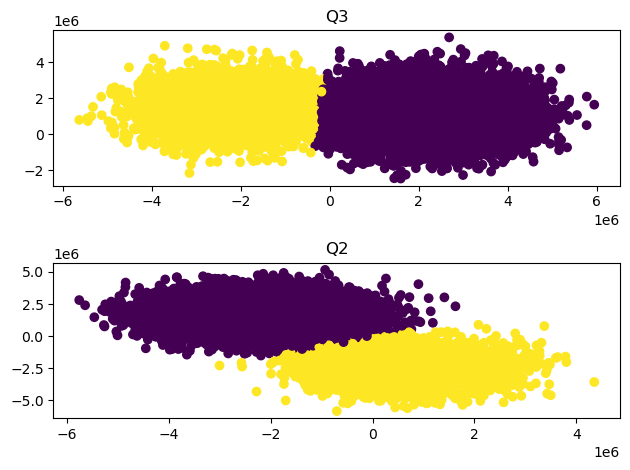

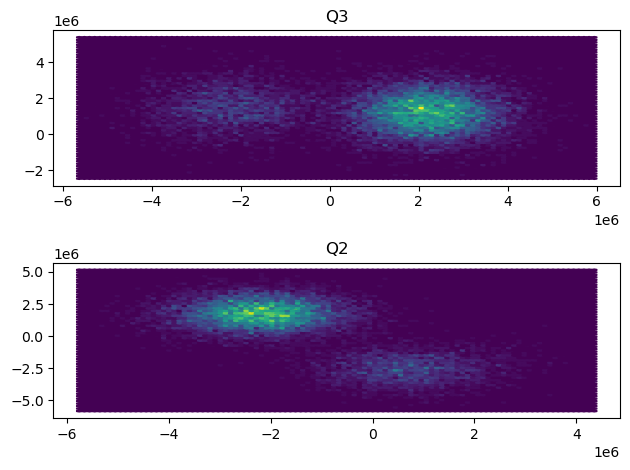

In [39]:
gmm_rabi = _rabi.GMMRabi([control, target], 0.3, np.linspace(0, 100e-9, 10), channel_config)
gmm_rabi.run_and_report(jobman, 1000, qchip)

In [56]:
jm = _jm.JobManager(fpga_config, channel_config, runner, qchip, gmm_rabi.gmm_manager)

In [69]:
widths = np.linspace(100.e-9, 220.e-9, 20)

In [74]:
control = 'Q3'
target = 'Q2'
r = []
tomo_list = []
#shot order: 0: ctrl0, x; 1: ctrl0, y; 2: ctrl0, z; 3: ctrl1, x; 4: ctrl1, y; 5: ctrl1, z
for width in widths:
    circuits = cr_sweep_circuit(control, target, width, .4)
    shotsout = jm.build_and_run_circuits(circuits, 1000, outputs=['shots'])['shots']
    target_avg = np.average(shotsout[target], axis=1)
    tomo_list.append(target_avg)

In [75]:
tomo_arr = np.asarray(tomo_list)
tomo_arr = tomo_arr*2-1

In [76]:
tomo_arr.shape
r_sum = 0.5*np.sqrt((tomo_arr[:,3] + tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] + tomo_arr[:,1])**2 + (tomo_arr[:,5] + tomo_arr[:,2])**2)
r = 0.5*np.sqrt((tomo_arr[:,3] - tomo_arr[:,0])**2 +
            + (tomo_arr[:,4] - tomo_arr[:,1])**2 + (tomo_arr[:,5] - tomo_arr[:,2])**2)
r_td = 0.5*(abs(tomo_arr[:,3] - tomo_arr[:,0]) +
            + abs(tomo_arr[:,4] - tomo_arr[:,1]) + abs(tomo_arr[:,5] - tomo_arr[:,2]))

In [79]:
circuits

[[{'name': 'delay', 't': 0.0004, 'qubit': ['Q2', 'Q3']},
  {'name': 'CR',
   'qubit': ['Q3', 'Q2'],
   'modi': {(0, 'twidth'): 2.2e-07, (0, 'amp'): 0.4}},
  {'name': 'Y-90', 'qubit': ['Q2']},
  {'name': 'read', 'qubit': ['Q3']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q2', 'Q3']},
  {'name': 'CR',
   'qubit': ['Q3', 'Q2'],
   'modi': {(0, 'twidth'): 2.2e-07, (0, 'amp'): 0.4}},
  {'name': 'X90', 'qubit': ['Q2']},
  {'name': 'read', 'qubit': ['Q3']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q2', 'Q3']},
  {'name': 'CR',
   'qubit': ['Q3', 'Q2'],
   'modi': {(0, 'twidth'): 2.2e-07, (0, 'amp'): 0.4}},
  {'name': 'read', 'qubit': ['Q3']},
  {'name': 'read', 'qubit': ['Q2']}],
 [{'name': 'delay', 't': 0.0004, 'qubit': ['Q2', 'Q3']},
  {'name': 'X90', 'qubit': ['Q3']},
  {'name': 'X90', 'qubit': ['Q3']},
  {'name': 'CR',
   'qubit': ['Q3', 'Q2'],
   'modi': {(0, 'twidth'): 2.2e-07, (0, 'amp'): 0.4}},
  {'name':

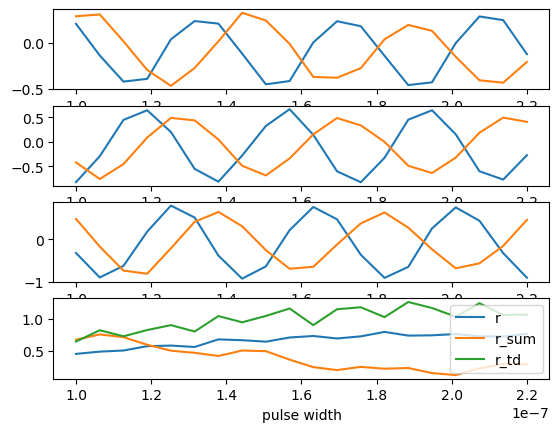

In [77]:
fig, axs = plt.subplots(4,1)
axs[0].plot(widths, tomo_arr[:,0], label='x0')
axs[1].plot(widths, tomo_arr[:,1], label='y0')
axs[2].plot(widths, tomo_arr[:,2], label='z0')
axs[0].plot(widths, tomo_arr[:,3], label='x1')
axs[1].plot(widths, tomo_arr[:,4], label='y1')
axs[2].plot(widths, tomo_arr[:,5], label='z1')
axs[3].plot(widths, r, label='r')
axs[3].plot(widths, r_sum, label='r_sum')
axs[3].plot(widths, r_td, label='r_td')


plt.xlabel('pulse width')
plt.legend()

In [ ]:
fig, axs = plt.subplots(4,1)
axs[0].plot(widths, tomo_arr[:,3] - tomo_arr[:,0], label='x')
axs[1].plot(widths, tomo_arr[:,4] - tomo_arr[:,1], label='y')
axs[2].plot(widths, tomo_arr[:,5] - tomo_arr[:,2], label='z')
axs[3].plot(widths, r, label='r')
axs[3].plot(widths, r_sum, label='r_sum')

plt.xlabel('pulse width')
plt.legend()

In [ ]:
|z1 - z0|
z0 = -1; z1 = 1
<Z> -1, 1
0, 1